In [99]:
import sys
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [100]:
DATASET_PATH = './data/comandos/'

data_dir = pathlib.Path(DATASET_PATH)

In [101]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['cero' 'cruz' 'no' 'ruido' 'si']


In [102]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.4,
    seed=0,
    output_sequence_length=9000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 375 files belonging to 5 classes.
Using 225 files for training.
Using 150 files for validation.

label names: ['cero' 'cruz' 'no' 'ruido' 'si']


This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [103]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [104]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [105]:
for example_audio, example_labels in val_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 9000)
(64,)


Let's plot a few audio waveforms:

In [106]:
label_names[[1,1,3,0]]

array(['cruz', 'cruz', 'ruido', 'cero'], dtype='<U5')

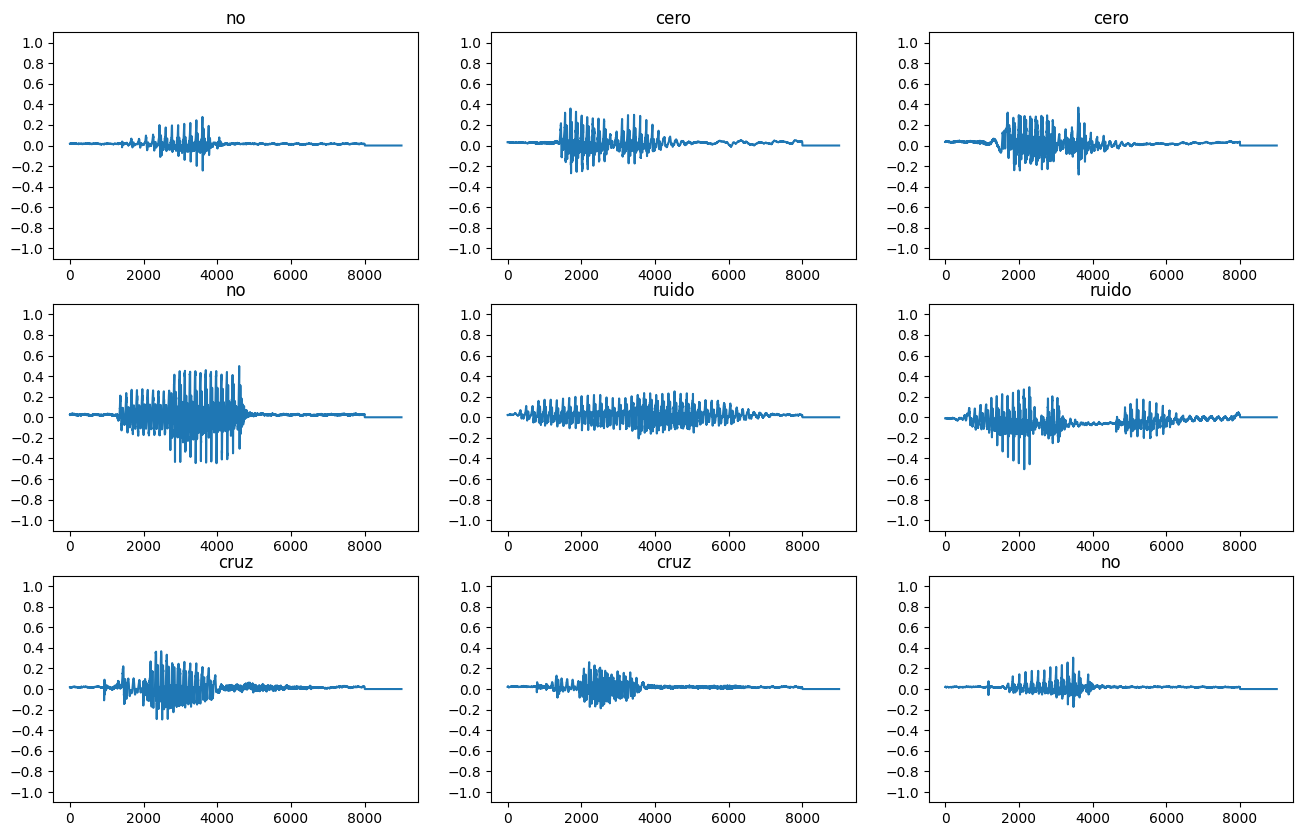

In [107]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [108]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [109]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (9000,)
Spectrogram shape: (69, 129, 1)
Audio playback


Label: cero
Waveform shape: (9000,)
Spectrogram shape: (69, 129, 1)
Audio playback


Label: cero
Waveform shape: (9000,)
Spectrogram shape: (69, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [110]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

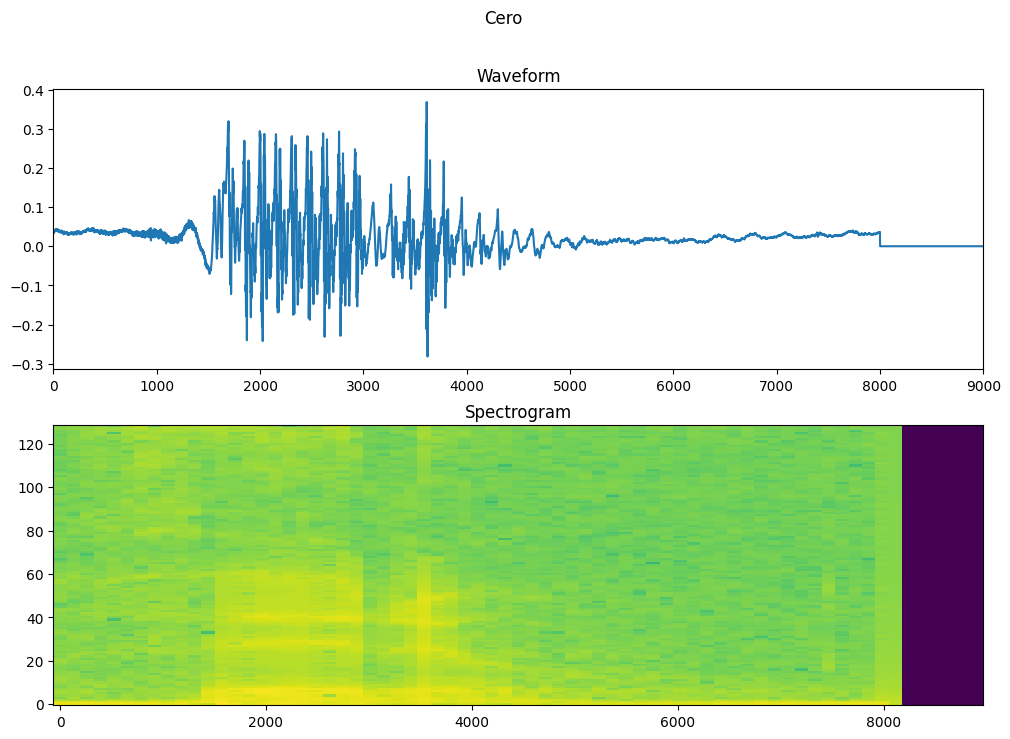

In [111]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 9000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [112]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [113]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [114]:
test_spectrogram_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 69, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Examine the spectrograms for different examples of the dataset:

In [115]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

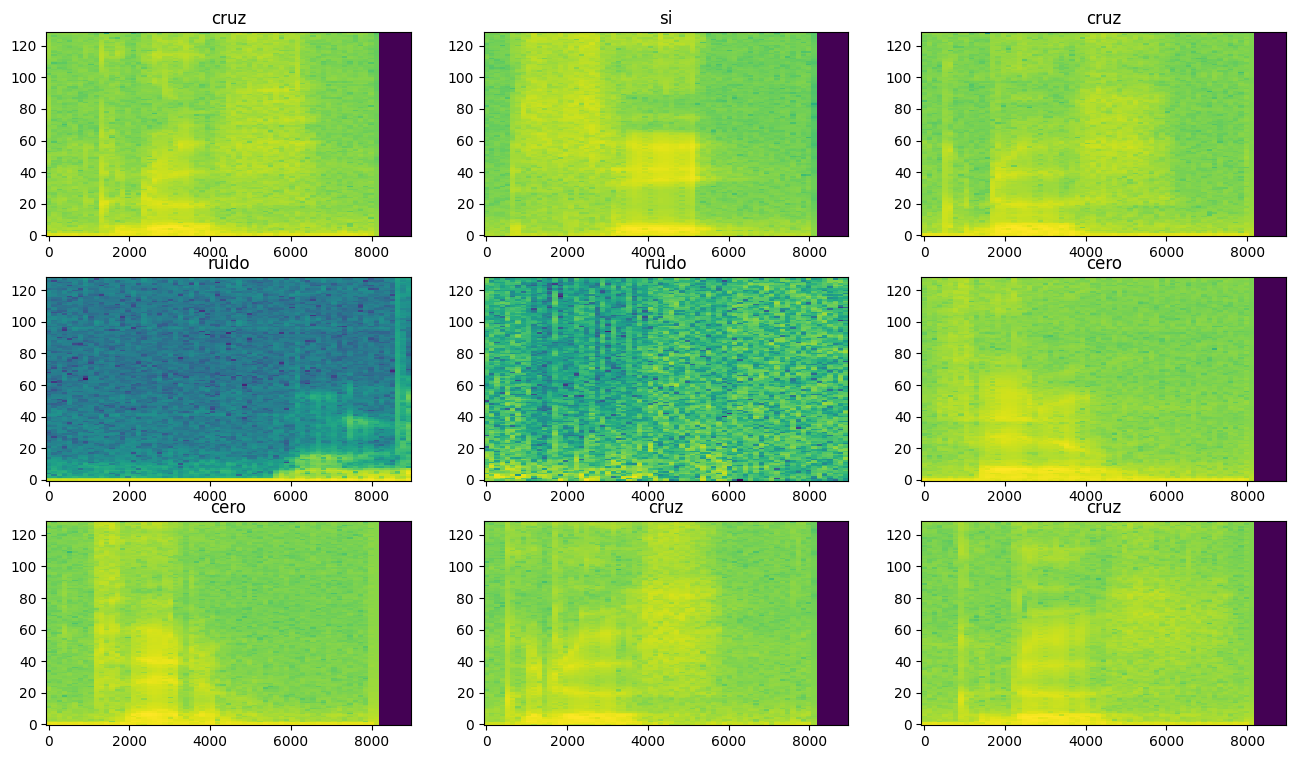

In [116]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

In [117]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# # Instantiate the `tf.keras.layers.Normalization` layer.
# norm_layer = layers.Normalization()
# # Fit the state of the layer to the spectrograms
# # with `Normalization.adapt`.
# norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # # Normalize.
    # norm_layer,
    layers.Conv2D(6,3, activation='relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(num_labels,activation='softmax'),
])

model.summary()

Input shape: (69, 129, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 6)         0         
                                                                 
 flatten_3 (Flatten)         (None, 5400)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 27005     
                                                                 
Total params: 27065 (105.72 KB)
Trainable params: 27065 (105.72 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [118]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [119]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


c:\Users\34699\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 2s 174ms/step - loss: 1.5335 - accuracy: 0.3422 - val_loss: 1.3864 - val_accuracy: 0.6562
Epoch 2/10
4/4 [==============================] - 0s 81ms/step - loss: 1.3272 - accuracy: 0.6800 - val_loss: 1.2220 - val_accuracy: 0.9219
Epoch 3/10
4/4 [==============================] - 0s 90ms/step - loss: 1.2022 - accuracy: 0.8178 - val_loss: 1.0837 - val_accuracy: 0.9375
Epoch 4/10
4/4 [==============================] - 0s 80ms/step - loss: 1.0275 - accuracy: 0.8978 - val_loss: 1.0475 - val_accuracy: 0.9688
Epoch 5/10
4/4 [==============================] - 0s 85ms/step - loss: 0.9102 - accuracy: 0.9289 - val_loss: 0.9633 - val_accuracy: 0.9531
Epoch 6/10
4/4 [==============================] - 0s 78ms/step - loss: 0.7911 - accuracy: 0.9156 - val_loss: 0.8559 - val_accuracy: 0.9531
Epoch 7/10
4/4 [==============================] - 0s 87ms/step - loss: 0.6822 - accuracy: 0.9111 - val_loss: 0.7477 - val_accuracy: 0.9375
Epoch 8/10
4/4 [=====================

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

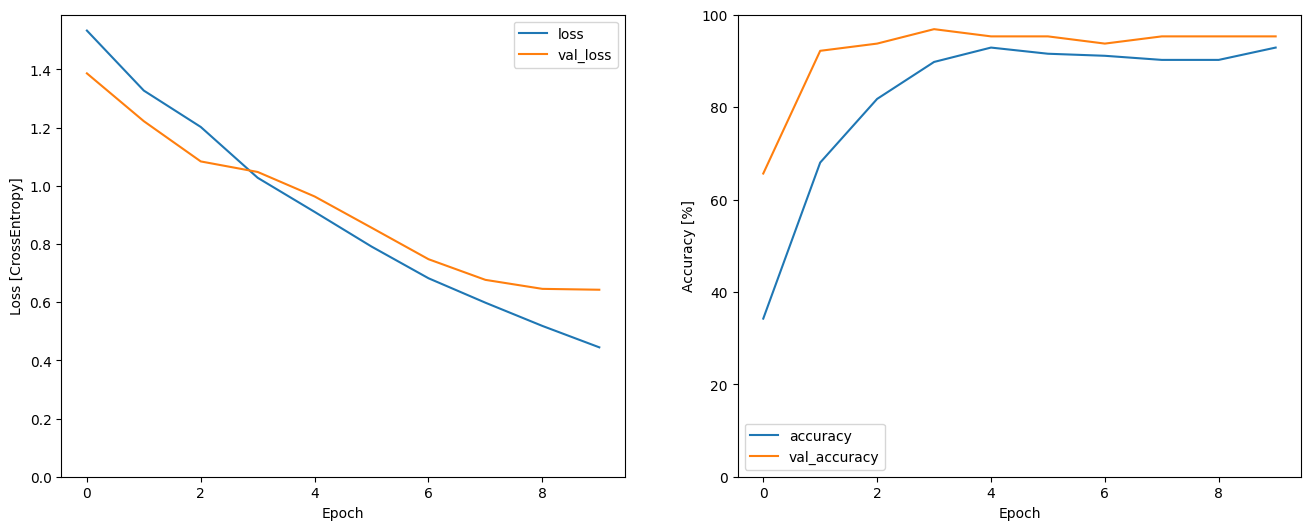

In [120]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [121]:
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 [==============================] - 0s 19ms/step - loss: 0.4166 - accuracy: 0.9186


{'loss': 0.416613906621933, 'accuracy': 0.9186046719551086}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [122]:
y_pred = model.predict(test_spectrogram_ds)

2/2 [==============================] - 0s 30ms/step


In [123]:
y_pred = tf.argmax(y_pred, axis=1)

In [124]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

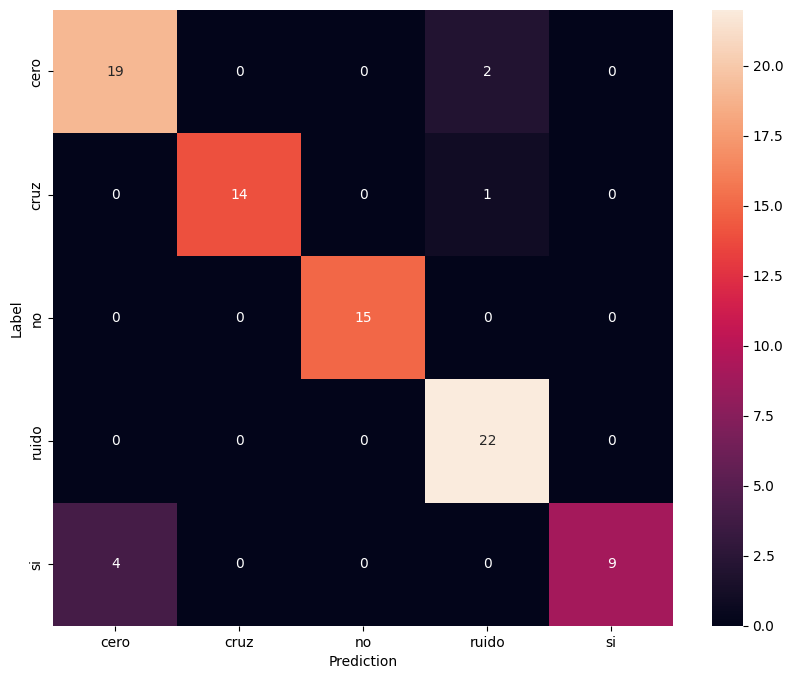

In [125]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

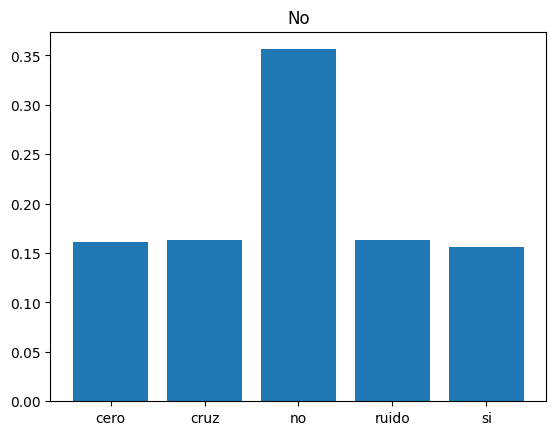

In [126]:
x = data_dir/'no/No_007.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=9000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=9000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [127]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 9000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=9000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [128]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/No_007.wav')))

{'predictions': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.04202924, 0.05281358, 0.835701  , 0.0571425 , 0.01231367]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [129]:
# Crear un generador representativo
def representative_dataset_generator():
    for audio, label in train_spectrogram_ds.take(100):  # Ajusta el tamaño según sea necesario
        yield [audio]

# Crear el convertidor de TensorFlow Lite desde el modelo Keras
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Configurar la cuantización
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]  # Configurar para enteros de 8 bits
converter.representative_dataset = representative_dataset_generator

# Configurar cuantización de entrada y salida
converter.inference_input_type = tf.float32  # Tipo de datos de entrada de la cuantización
converter.inference_output_type = tf.float32  # Tipo de datos de salida de la cuantización

# Convertir el modelo a TensorFlow Lite
tflite_model = converter.convert()

# Guardar el modelo TFLite
with open('modelo_rec_reducido.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\34699\AppData\Local\Temp\tmpfy0vwre3\assets


INFO:tensorflow:Assets written to: C:\Users\34699\AppData\Local\Temp\tmpfy0vwre3\assets
c:\Users\34699\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [130]:
interpreter = tf.lite.Interpreter(model_path='./modelo_rec_reducido.tflite')
interpreter.allocate_tensors()
input_tensor_index = interpreter.get_input_details()[0]['index']
output_tensor_index = interpreter.get_output_details()[0]['index']

y_true = []  # Lista para almacenar las etiquetas reales
y_pred = []  # Lista para almacenar las predicciones

# Imprimir las dimensiones esperadas del tensor de enStrada y salida
input_shape = interpreter.get_input_details()[0]['shape']
output_shape = interpreter.get_output_details()[0]['shape']


for data, labels in test_spectrogram_ds:  # Iterar sobre el conjunto de datos de prueba
    # Iterar sobre cada muestra en el lote
    for i in range(data.shape[0]):
        # Seleccionar la muestra i del lote
        sample_data = data[i:i+1]  # Asegura que el tamaño del lote sea 1

        interpreter.set_tensor(input_tensor_index, sample_data)
        interpreter.invoke()
        output_tensor = interpreter.get_tensor(output_tensor_index)

        # Asumiendo que output_tensor tiene la forma (1, num_classes)
        predicted_classes = np.argmax(output_tensor, axis=1)

        y_true.append(labels.numpy()[i])
        y_pred.append(predicted_classes[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular la precisión
accuracy = np.mean(y_true == y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 89.53%


Observamos que se mantiene la precisión